# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of four classes: Normal, Viral, Pneumonio, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

### About COVID-19 Dataset
A database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. This COVID-19 dataset contains 3616 COVID-19 positive cases along with 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection) and 1345 Viral Pneumonia images.

In [ ]:
# Import necessary libraries for warnings and suppress any warnings that may clutter the output
import warnings
warnings.filterwarnings('ignore')

# Configure inline plotting for Jupyter Notebooks (only necessary in notebooks)
%matplotlib inline

# Import libraries for file management, PyTorch, image transformations, and model visualization
import os  # Operating system interfaces for file and directory operations
import shutil  # High-level file operations such as copying and removing directories
import random  # Generate random numbers and perform random operations
import torch  # Main PyTorch library for tensor operations and model building
import torchvision  # Library for image-related tasks, models, and utilities
from torchvision import models, transforms  # Import pre-trained models and image transformations
from torch.utils.data import DataLoader  # For batching, sampling, and data loading

# Import numerical and visualization libraries
import numpy as np  # Numerical operations with arrays
from sklearn.metrics import confusion_matrix  # For calculating confusion matrix for classification results
from mlxtend.plotting import plot_confusion_matrix  # Visualization for confusion matrix
import seaborn as sns  # Advanced data visualization library
from PIL import Image  # Image processing capabilities
from matplotlib import pyplot as plt  # Main plotting library

# Import helper functions for model summary and evaluation metrics
from torchsummary import summary  # Model summary for visualization of layer details
from sklearn.metrics import classification_report  # Detailed report on classification metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score  # ROC, AUC, and other metrics for model evaluation
from tqdm import tqdm  # Progress bar for loops

# Import OpenCV and PyTorch Grad-CAM for visual explanations of model decisions
import cv2  # Computer vision library for image and video processing
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM  # Grad-CAM methods for model interpretability
from pytorch_grad_cam.utils.image import show_cam_on_image  # Helper for overlaying Grad-CAM heatmaps on images

# Set the style for Seaborn plots to a clean white grid background
sns.set_style("whitegrid")

# Set random seed for PyTorch to ensure reproducible results
torch.manual_seed(0)


In [ ]:
# Check if CUDA (GPU support) is available on the machine
print('cuda available' if torch.cuda.is_available() else 'cuda not available')

# Set the device to GPU (cuda:0) if available; otherwise, use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print out which device will be used for tensor operations
print('device:', device)


cuda not available
device: cpu


# Data Preparation

In [ ]:
# Import necessary modules for file operations, random selection, and numerical operations
import os  # Provides functions for interacting with the file system
import shutil  # High-level file and directory management operations
import random  # Provides functions to generate random selections
import numpy as np  # Provides support for large, multi-dimensional arrays and matrices

# Define class names and their respective labels for easier data handling
class_names = ['normal', 'viral', 'covid', 'lung']  # Short names for each class
class_fullnames = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung Opacity']  # Full names of the classes
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung_Opacity']  # Original directory names in the dataset
root_dir = 'COVID-19_Radiography_Dataset'  # Root directory of the dataset

# Set the number of test and validation images per class
test_cases = 100  # Number of images per class for the test split
valid_cases = 100  # Number of images per class for the validation split
num_classes = len(class_names)  # Total number of classes

# Define mean and standard deviation for normalization (typical values for pre-trained models on ImageNet)
mean = np.array([0.485, 0.456, 0.406])  # Mean values for RGB channels
std = np.array([0.229, 0.224, 0.225])  # Standard deviation values for RGB channels

# Define function to create dataset splits (validation or test)
def create_split(split, num_cases):
    # Create the split directory (e.g., valid or test) if it doesn't already exist
    split_dir = os.path.join(root_dir, split)
    if not os.path.isdir(split_dir):
        os.mkdir(split_dir)
        
    # Rename directories if needed to match class names with `class_names` list
    for i, d in enumerate(source_dirs):
        source_path = os.path.join(root_dir, d)
        target_path = os.path.join(root_dir, class_names[i])
        if os.path.isdir(source_path):
            os.rename(source_path, target_path)

    # Create individual class folders in the split directory for images
    for c in class_names:
        os.makedirs(os.path.join(split_dir, c, 'images'), exist_ok=True)

    # Move a specified number of images for each class into the split directory
    for i, c in enumerate(class_names):
        images_path = os.path.join(root_dir, c, 'images')  # Path to the original images
        images = [x for x in os.listdir(images_path) if x.lower().endswith('png')]  # List of all PNG images in the folder
        selected_images = random.sample(images, min(len(images), num_cases))  # Randomly select `num_cases` images

        # Move each selected image to the split directory for the respective class
        for image in selected_images:
            source_path = os.path.join(images_path, image)  # Original location of the image
            target_path = os.path.join(split_dir, c, 'images', image)  # Target location for the split
            shutil.move(source_path, target_path)  # Move the image

# Create validation and test splits by calling the function with specified parameters
create_split('valid', valid_cases)  # Create validation set
create_split('test', test_cases)  # Create test set


In [ ]:
# Import necessary libraries for file handling, image processing, and PyTorch
import os  # Provides functions for interacting with the file system
import numpy as np  # Provides support for large, multi-dimensional arrays and matrices
from PIL import Image  # For opening, manipulating, and saving image files
import torch  # Main PyTorch library for tensor operations and model building
from torch.utils.data import Dataset  # Base class for PyTorch datasets

# Define a custom dataset class for Chest X-ray images, inheriting from PyTorch's Dataset
class ChestXRayDataset(Dataset):
    def __init__(self, image_dirs, transform=None):
        """
        Initializes the dataset by collecting image paths and labels.
        
        Parameters:
        - image_dirs: A dictionary where keys are class names, and values are directory paths for each class.
        - transform: Transformations to apply to each image (e.g., resizing, normalization).
        """
        self.transform = transform  # Store the transform function
        self.images = []  # List to store paths of images
        self.labels = []  # List to store labels corresponding to each image
        
        # Gather images and labels from each class-specific directory
        for label, (class_name, dir_path) in enumerate(image_dirs.items()):
            if not os.path.isdir(dir_path):  # Skip if the directory does not exist
                continue
            
            # Define the path to the 'images' subdirectory in each class folder
            images_path = os.path.join(dir_path, 'images')
            if os.path.isdir(images_path):
                # Iterate over files in the 'images' subdirectory
                for image_file in os.listdir(images_path):
                    if image_file.lower().endswith('.png'):  # Only consider PNG images
                        image_path = os.path.join(images_path, image_file)  # Full path to the image
                        self.images.append(image_path)  # Add image path to the list
                        self.labels.append(label)  # Add corresponding label to the list
        
        # Convert labels list to a numpy array for easier handling
        self.labels = np.array(self.labels)

    def __len__(self):
        """
        Returns the total number of images in the dataset.
        """
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        class_id = self.labels[idx]
        
        # Open image and enforce RGB conversion
        
        image = Image.open(image_path)
        
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        
        return image, class_id


In [ ]:
# Define transformations for the training set
train_transform = torchvision.transforms.Compose([
    transforms.Resize((224,224)),  # Resize images to 224x224 pixels
    transforms.RandomRotation(20),  # Randomly rotate images by up to 20 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ToTensor(),  # Convert images to PyTorch tensors and normalize pixel values to [0, 1]
    transforms.Normalize(mean=mean, std=std)  # Normalize using predefined mean and std for each RGB channel
])

# Define transformations for the test/validation set
test_transform = torchvision.transforms.Compose([
    transforms.Resize((224,224)),  # Resize images to 224x224 pixels
    transforms.CenterCrop(224),  # Center-crop images to a 224x224 region
    transforms.ToTensor(),  # Convert images to PyTorch tensors and normalize pixel values to [0, 1]
    transforms.Normalize(mean=mean, std=std)  # Normalize using predefined mean and std for each RGB channel
])


In [ ]:
# Create dictionaries that map each class name to its directory path in the dataset
train_dirs = {p : os.path.join(root_dir, p) for p in class_names}  # Paths for training data
test_dirs = {p : os.path.join(root_dir, 'test', p) for p in class_names}  # Paths for test data
valid_dirs = {p : os.path.join(root_dir, 'valid', p) for p in class_names}  # Paths for validation data

# Create dataset instances using the ChestXRayDataset class, specifying directories and transformations
train_dataset = ChestXRayDataset(train_dirs, train_transform)  # Training dataset with augmentations
test_dataset = ChestXRayDataset(test_dirs, test_transform)  # Test dataset without augmentations
valid_dataset = ChestXRayDataset(valid_dirs, test_transform)  # Validation dataset without augmentations


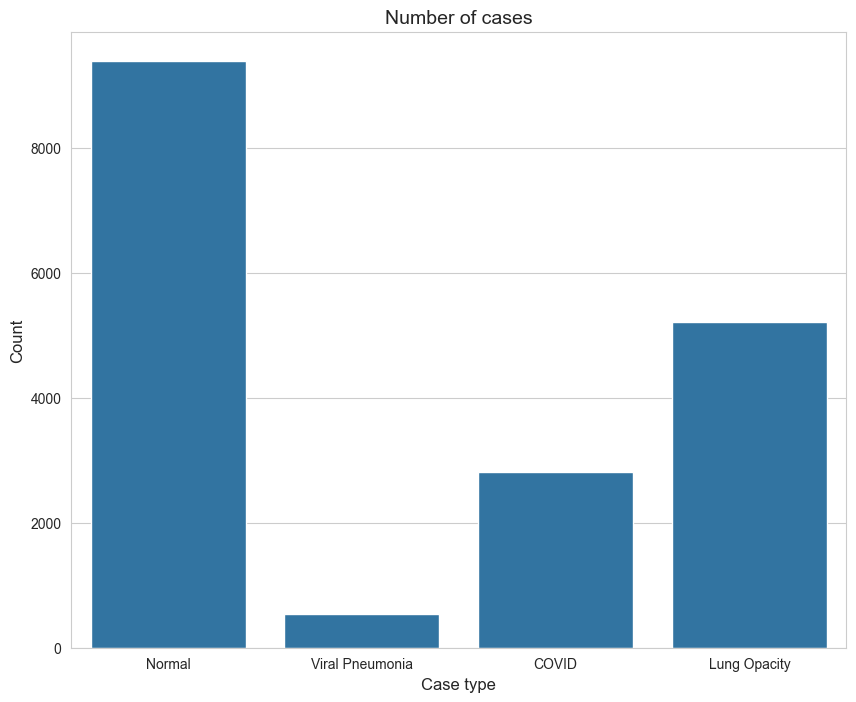

In [ ]:
# Initialize an empty list to store the count of cases for each class
cases_count = []
for idx in range(num_classes):
    # Count the number of occurrences of each class label in the training dataset
    cases_count.append(np.sum(train_dataset.labels == idx))

# Plot the results using a bar plot
plt.figure(figsize=(10,8))  # Set the figure size
sns.barplot(x=class_fullnames, y=cases_count)  # Create a bar plot with case types on the x-axis and counts on the y-axis
plt.title('Number of cases', fontsize=14)  # Set the title of the plot
plt.xlabel('Case type', fontsize=12)  # Label for the x-axis
plt.ylabel('Count', fontsize=12)  # Label for the y-axis
plt.show()  # Display the plot


In [ ]:
# Define batch size for loading the data
batch_size = 16

# Create DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle enabled for random sampling in training

# Create DataLoader for the test dataset
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Shuffle disabled for consistent testing

# Create DataLoader for the validation dataset
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)  # Shuffle disabled for consistent validation


In [ ]:
def show_images(images, labels, preds):
    # Create a figure with a specified size
    plt.figure(figsize=(20,6))
    
    # Loop over images to display, with a maximum of 5 images
    for i, image in enumerate(images):
        if i > 4:
            break  # Stop after displaying 5 images
        
        # Create a subplot for each image
        plt.subplot(1, 5, i+1, xticks=[], yticks=[])
        
        # Convert the image tensor to a numpy array and transpose to (height, width, channels)
        image = image.cpu().detach().numpy().transpose((1, 2, 0))
        
        # De-normalize the image to revert to original pixel values
        image = image * std + mean
        
        # Clip pixel values to ensure they are within the range [0, 1] for display
        image = np.clip(image, 0., 1.)
        
        # Display the image
        plt.imshow(image)
        
        # Label the image with its true class name
        plt.xlabel(f'{class_fullnames[int(labels[i].numpy())]}')


Augmented data:


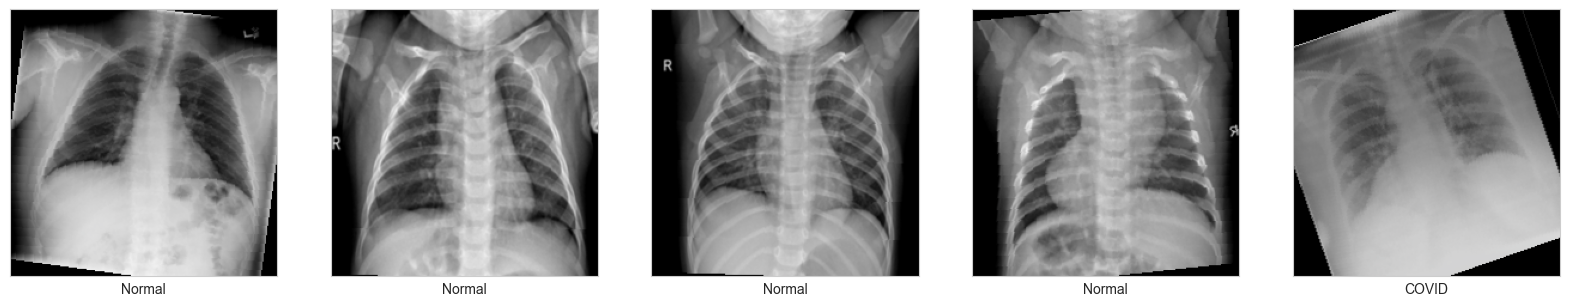

In [ ]:
# Retrieve a single batch of images and labels from the training DataLoader
images, labels = next(iter(train_loader))

# Print a message to indicate that these are augmented images
print('Augmented data:')

# Call the show_images function to display the images and their corresponding labels
show_images(images, labels, labels)


# Modeling

Load Pretrained Model

In [ ]:
import torch  # Import PyTorch library
from torchvision import models  # Import the models module from torchvision

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNet-18 model
# The pretrained=True argument downloads weights trained on ImageNet
resnet18 = models.resnet18(pretrained=True).to(device)  # Move the model to the selected device (GPU or CPU)


Model Summary Output

In [ ]:
import sys  # Import the sys library to handle system-level functions
from torchsummary import summary  # Import the summary function from torchsummary to get model details

# Redirect output to a file
with open("resnet18_summary.txt", "w") as f:
    sys.stdout = f  # Redirect standard output to the file
    summary(resnet18, (3, 224, 224))  # Print the model summary to the file; (3, 224, 224) specifies input size for a 3-channel 224x224 image
    sys.stdout = sys.__stdout__  # Reset standard output back to default


Modify the Model and Define Loss and Optimizer

In [ ]:
import torch.nn as nn  # Import the neural network module
import torch.optim as optim  # Import the optimization module

# Define the number of output classes (adjust to your specific use case)
num_classes = 4

# Modify the fully connected (fc) layer of ResNet-18 to match the number of classes
# ResNet-18's original fc layer has 512 input features; we change the output to match num_classes
resnet18.fc = nn.Linear(in_features=512, out_features=num_classes).to(device)

# Define the loss function
# CrossEntropyLoss is commonly used for classification tasks
criterion = nn.CrossEntropyLoss()

# Define the optimizer
# Adam is a popular optimizer that adapts the learning rate for each parameter
# lr=3e-5 is the learning rate, which controls the step size for each update
optimizer = optim.Adam(resnet18.parameters(), lr=3e-5)


In [ ]:
# Move the modified ResNet-18 model to the specified device (CPU or GPU)
resnet18 = resnet18.to(device)


In [ ]:
import sys  # Import system module to manipulate standard output
from torchsummary import summary  # Import summary from torchsummary to display model architecture

# Redirect output to a file
with open("resnet18_summary2.txt", "w") as f:
    # Store the original stdout
    original_stdout = sys.stdout
    # Redirect stdout to the file
    sys.stdout = f
    # Generate and write the model summary to the file; (3, 224, 224) specifies the input size
    summary(resnet18, (3, 224, 224))
    # Restore the original stdout to enable normal console output again
    sys.stdout = original_stdout


In [ ]:
def plot_value_array(i, predictions_array, true_label):
    # Select the true label for the i-th image
    true_label = true_label[i]
    # Disable grid lines for the plot
    plt.grid(False)
    # Set x-tick labels to the class names with a 50-degree rotation
    plt.xticks(range(num_classes), class_names, rotation=50)
    # Create a bar plot of the prediction probabilities
    thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
    # Set y-axis limits from 0 to 1 for probability scale
    plt.ylim([0, 1])
    # Identify the predicted label (highest probability)
    predicted_label = np.argmax(predictions_array)
    
    # Highlight the predicted label in red and the true label in blue
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
    
def show_images_with_preds(images, labels, soft_preds):
    # Initialize figure with specified dimensions
    plt.figure(figsize=(14,6))
    # Get predicted class labels from softmax predictions
    _, preds = torch.max(soft_preds, 1)

    for i, image in enumerate(images):
        if i > 4:
            break  # Limit to 5 images
            
        # Display each image in a subplot
        plt.subplot(2, 5, i+1, xticks=[], yticks=[])
        # Convert the image tensor to a numpy array and normalize it for display
        image = image.cpu().detach().numpy().transpose((1,2,0))
        image = image * std + mean  # Apply normalization
        image = np.clip(image, 0., 1.)  # Clip values to keep them within valid range
        plt.imshow(image)

        # Set the color of the label based on prediction accuracy
        col = 'blue' if preds[i] == labels[i] else 'red'
        
        # Display the predicted label, confidence, and true label below each image
        plt.xlabel("{} {:2.0f}% (truth: {})".format(class_names[int(preds[i].numpy())],
                                                    100 * np.max(soft_preds[i].numpy()),
                                                    class_names[labels[i]]),
                                                    color=col)
        
        # Plot the prediction probability array for each image
        plt.subplot(2, 5, 6+i, xticks=[], yticks=[])
        plot_value_array(i, soft_preds[i], labels)
        
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

def visualize_preds():
    # Set the model to evaluation mode
    resnet18.eval()
    # Fetch a batch of test images and labels
    images, labels = next(iter(test_loader))
    images = images.to(device)  # Move images to the specified device
    # Obtain model predictions
    outputs = resnet18(images)
    outputs = outputs.cpu().detach()  # Move predictions back to CPU
    # Apply softmax to get prediction probabilities
    soft_preds = torch.softmax(outputs, dim=1)   
    
    # Display images with predictions
    show_images_with_preds(images, labels, soft_preds)


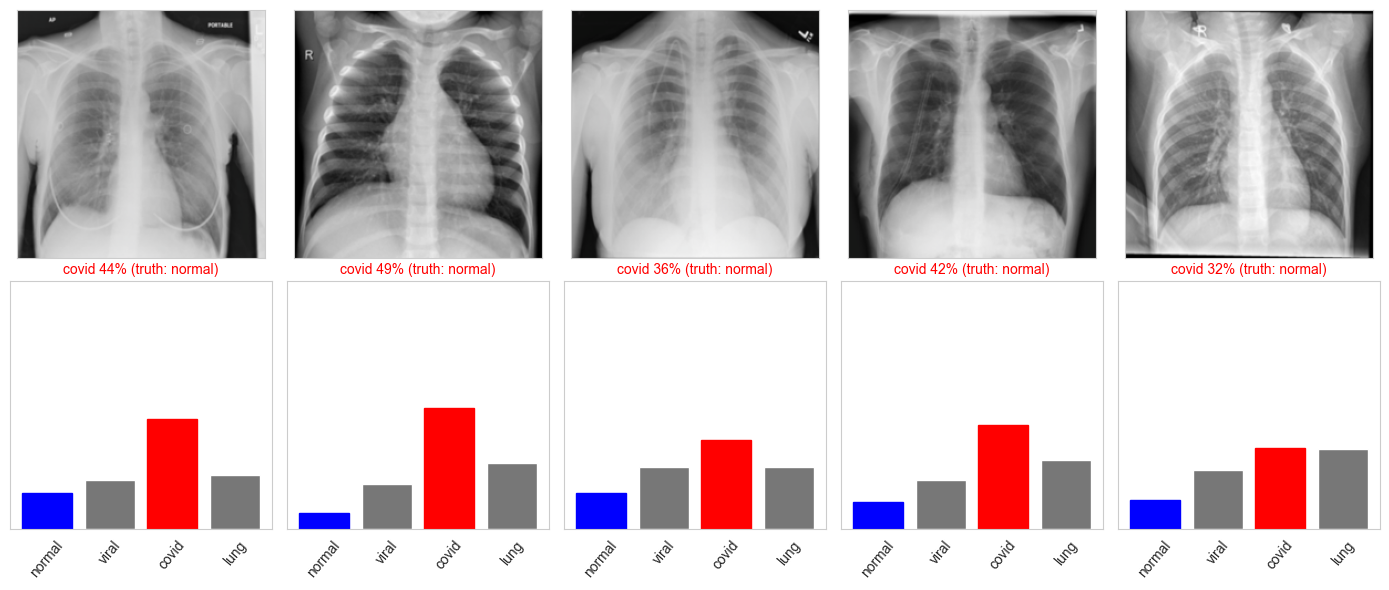

In [ ]:
# Print a message to indicate pre-training predictions
print('Predictions before training')

# Visualize model predictions before training
visualize_preds()


In [ ]:
# Initialize lists to track losses and accuracies over epochs
train_losses = []
train_accuracies = []

def train(epoch):
    # Print the epoch number for tracking progress
    print('\nEpoch : %d' % epoch)

    # Set the model to training mode
    resnet18.train()
    # Initialize variables to track running loss and accuracy
    running_loss = 0
    correct = 0
    total = 0      

    # Iterate over the training data
    for data in tqdm(train_loader):
        # Load images and labels to the specified device
        images, labels = data[0].to(device), data[1].to(device).long()
        # Reset gradients to zero
        optimizer.zero_grad()
    
        # Forward pass: compute model predictions
        outputs = resnet18(images)
        # Compute the loss between predictions and true labels
        loss = criterion(outputs, labels)
        # Backward pass: compute gradients
        loss.backward()
        # Update model parameters
        optimizer.step()
        
        # Accumulate the total running loss for the epoch
        running_loss += loss.item()
        # Get predicted labels by taking the maximum predicted probability
        _, preds = torch.max(outputs, 1)
        # Update the count of correct predictions
        correct += torch.sum(preds == labels).item()
        # Update the total count of labels processed
        total += labels.size(0)
      
    # Compute average loss and accuracy for the epoch
    train_loss = running_loss / len(train_loader)
    acc = 100. * correct / total
  
    # Append the results to track training progress
    train_accuracies.append(acc)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f' % (train_loss, acc))          


In [ ]:
# Initialize lists to store loss and accuracy for evaluation
eval_losses = []
eval_accuracies = []

def test(epoch):
    # Set the model to evaluation mode
    resnet18.eval()
    # Initialize variables to track running loss and accuracy
    running_loss = 0
    correct = 0
    total = 0

    # Disable gradient calculations to speed up inference and reduce memory usage
    with torch.no_grad():
        # Iterate over the validation dataset
        for data in tqdm(valid_loader):
            # Load images and labels to the specified device
            images, labels = data[0].to(device), data[1].to(device).long()

            # Forward pass: get model outputs
            outputs = resnet18(images)
            # Compute the loss
            loss = criterion(outputs, labels)
            
            # Accumulate the total loss for the epoch
            running_loss += loss.item()
            
            # Get predictions by finding the index with the highest score
            _, preds = torch.max(outputs, 1)
            # Update the count of correct predictions
            correct += (preds == labels).sum().item()
            # Update the total count of labels processed
            total += labels.size(0)

    # Calculate the average loss and accuracy for this epoch
    test_loss = running_loss / len(valid_loader)
    acc = 100. * correct / total

    # Append results to lists for tracking and plotting
    eval_losses.append(test_loss)
    eval_accuracies.append(acc)

    # Print out the metrics for this epoch
    print(f'Epoch {epoch} - Test Loss: {test_loss:.3f} | Accuracy: {acc:.3f}%')


In [ ]:
epochs = 10  # Define the number of epochs for training

# Training loop
for epoch in range(1, epochs + 1): 
    train(epoch)  # Train the model and collect training metrics
    test(epoch)   # Test the model and collect validation metrics


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


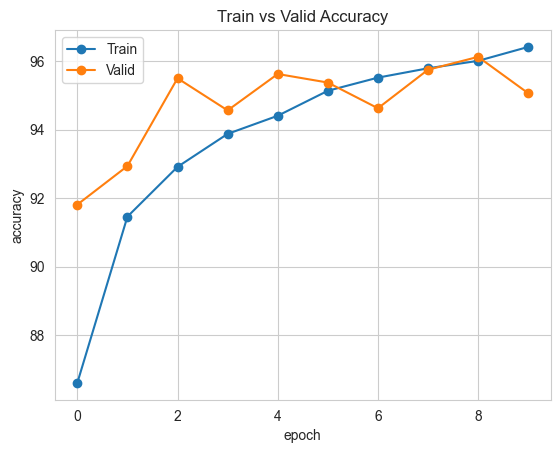

In [ ]:
# Plotting the training accuracy over epochs
plt.plot(train_accuracies, '-o', label='Train')  # Plot the training accuracies with circles for each epoch

# Plotting the validation accuracy over epochs
plt.plot(eval_accuracies, '-o', label='Valid')  # Plot the validation accuracies with circles for each epoch

# Labeling the x-axis with 'epoch'
plt.xlabel('epoch')  # Set the label for the x-axis to 'epoch'

# Labeling the y-axis with 'accuracy'
plt.ylabel('accuracy')  # Set the label for the y-axis to 'accuracy'

# Adding a legend to differentiate between training and validation accuracy
plt.legend()  # Display the legend based on the provided labels

# Adding a title to the plot
plt.title('Train vs Valid Accuracy')  # Set the title of the plot to 'Train vs Valid Accuracy'

# Display the plot
plt.show()  # Show the plot on the screen


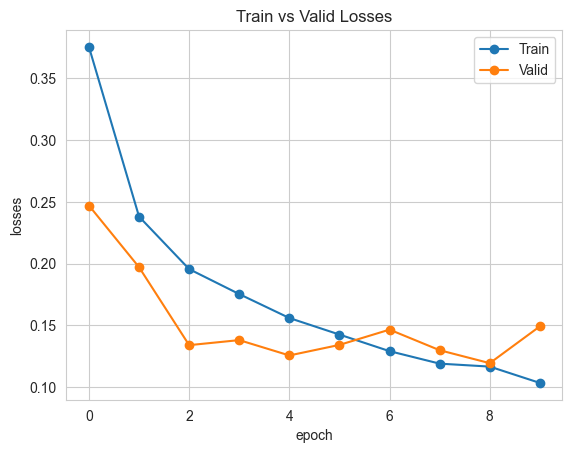

In [31]:
# Plotting the training losses over epochs
plt.plot(train_losses, '-o', label='Train')  # Plot the training losses with circles for each epoch

# Plotting the validation losses over epochs
plt.plot(eval_losses, '-o', label='Valid')  # Plot the validation losses with circles for each epoch

# Labeling the x-axis with 'epoch'
plt.xlabel('epoch')  # Set the label for the x-axis to 'epoch'

# Labeling the y-axis with 'losses'
plt.ylabel('losses')  # Set the label for the y-axis to 'losses'

# Adding a legend to differentiate between training and validation losses
plt.legend()  # Display the legend based on the provided labels

# Adding a title to the plot
plt.title('Train vs Valid Losses')  # Set the title of the plot to 'Train vs Valid Losses'

# Display the plot
plt.show()  # Show the plot on the screen


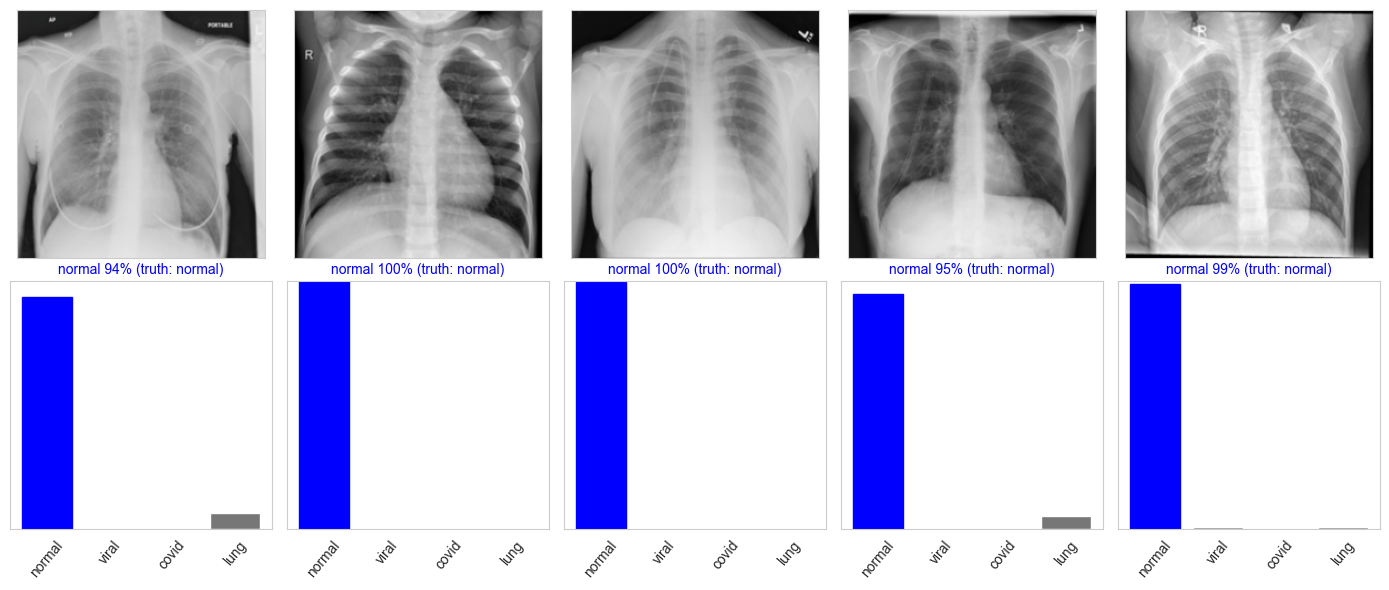

In [32]:
visualize_preds()

In [34]:
def eval_classifier(model, test_loader, plot_roc_curve=False):
    """
    Evaluate the classifier on the test set and optionally plot the confusion matrix and ROC curve.
    
    Parameters:
    - model: The trained model to evaluate.
    - test_loader: DataLoader for the test dataset.
    - plot_roc_curve: Whether to plot the ROC curve for each class (default is False).
    
    Returns:
    - score_list: The predicted scores (probabilities) for each class.
    """
    
    def indices_to_one_hot(data, nb_classes):
        """Convert an iterable of indices to one-hot encoded labels."""
        targets = np.array(data).reshape(-1)  # Flatten the labels array
        return np.eye(nb_classes)[targets]  # Create one-hot encoded labels
    
    model.eval()  # Set the model to evaluation mode
    
    # Initialize empty lists for storing predicted scores, predictions, and true labels
    score_list = torch.Tensor([])  # To store predicted probabilities
    pred_list = torch.Tensor([]).long()  # To store predicted class labels
    target_list = torch.Tensor([]).long()  # To store true class labels
    
    # Loop through the test dataset
    for iter_num, (images, labels) in enumerate(test_loader):        
        images, labels = images.to(device), labels.to(device)  # Send data to the correct device (GPU/CPU)
        outputs = model(images)  # Get model predictions (logits)
        
        labels = labels.cpu().detach()  # Detach labels from computation graph and move to CPU
        outputs = outputs.cpu().detach()  # Detach outputs from computation graph and move to CPU
        
        # Convert logits to probabilities using softmax and append to score list
        score_list = torch.cat([score_list, torch.nn.Softmax(dim=1)(outputs).squeeze()])
        
        # Append the true labels to the target list
        target_list = torch.cat([target_list, labels.squeeze()])
        
        # Get the class with the highest probability as the prediction
        _, preds = torch.max(outputs, 1)
        
        # Append predictions to pred list
        pred_list = torch.cat([pred_list, preds.squeeze()])
    
    # Convert lists to numpy arrays for further analysis
    pred_list = pred_list.numpy()
    target_list = target_list.numpy()
    score_list = score_list.numpy()
    
    # Calculate accuracy as the percentage of correct predictions
    accuracy = np.sum(target_list == pred_list) / len(pred_list) * 100.
    print(f'Total accuracy: {accuracy}%')
    
    # Compute confusion matrix
    cm = confusion_matrix(target_list, pred_list) 
    
    # Create subplots for confusion matrix and ROC curve
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    
    # Plot confusion matrix
    plot_confusion_matrix(cm, hide_ticks=True, cmap=plt.cm.Blues, axis=axes[0])
    
    axes[0].set_xlabel('Predicted labels', fontsize=12)
    axes[0].set_ylabel('True labels', fontsize=12)
    axes[0].set_xticks(range(4), class_fullnames, fontsize=11)  # Replace with actual class names
    axes[0].set_yticks(range(4), class_fullnames, fontsize=11)
    axes[0].set_title('Confusion Matrix', fontsize=16)
    
    # Convert target labels to one-hot encoding for ROC curve calculation
    target_list = indices_to_one_hot(target_list, num_classes)
    
    # Initialize dictionaries to store false positive rates (fpr), true positive rates (tpr), and AUC scores
    fpr, tpr, roc_auc = dict(), dict(), dict()

    # Loop through each class to calculate ROC curve data
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(target_list[:, i], score_list[:, i])  # Compute ROC curve for each class
        roc_auc[i] = auc(fpr[i], tpr[i])  # Compute AUC score for each class

    # Plot ROC curve for each class
    for i in range(num_classes):
        axes[1].plot(fpr[i], tpr[i], label=f'{class_fullnames[i]} (area = %0.5f)' % roc_auc[i])  # Plot each class' ROC curve
        axes[1].plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line (random classifier)
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('False Positive Rate', fontsize=12)
        axes[1].set_ylabel('True Positive Rate', fontsize=12)
        axes[1].set_title('ROC Curve', fontsize=16)
        axes[1].legend(loc="lower right")  # Display legend in the lower right
    
    # Adjust layout and show the plot
    plt.tight_layout()  
    plt.show()
    
    return score_list  # Return predicted scores (probabilities)


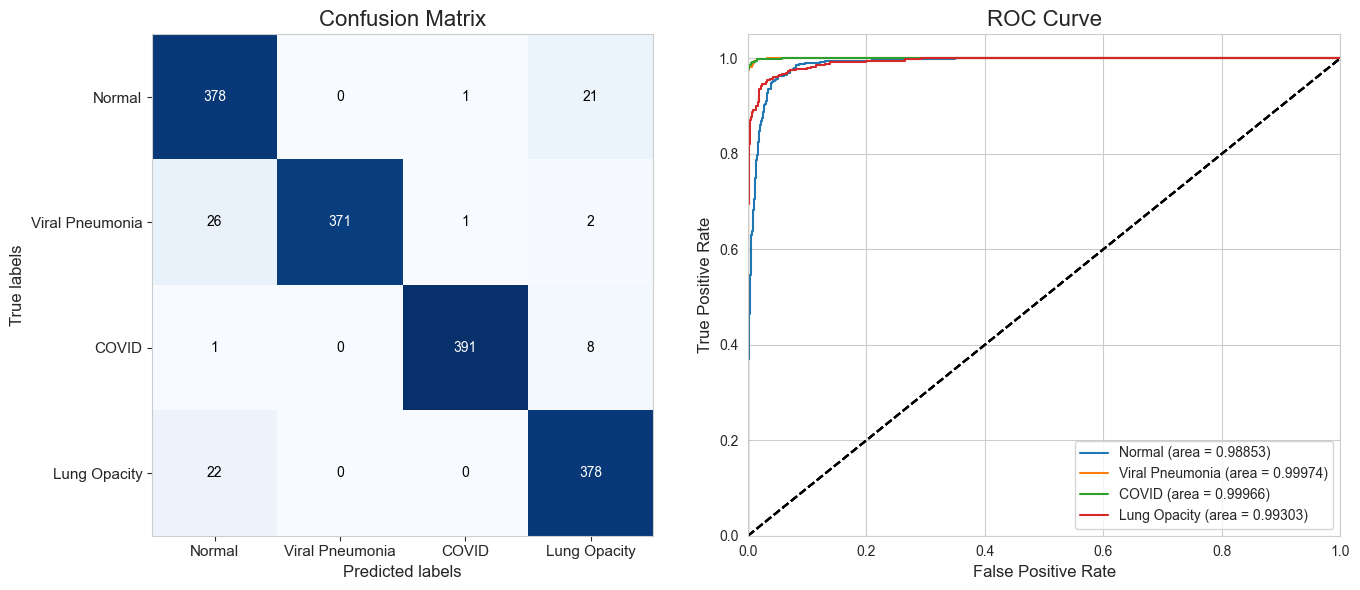

In [35]:
# Call the eval_classifier function to evaluate the ResNet-18 model on the test dataset
# The function will return the predicted scores (probabilities) for each class
# The model will be evaluated in evaluation mode, and confusion matrix and ROC curve will be plotted
scores = eval_classifier(resnet18, test_loader)


In [36]:
!pip install grad-cam

You should consider upgrading via the 'c:\users\jasmine jayaswal\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


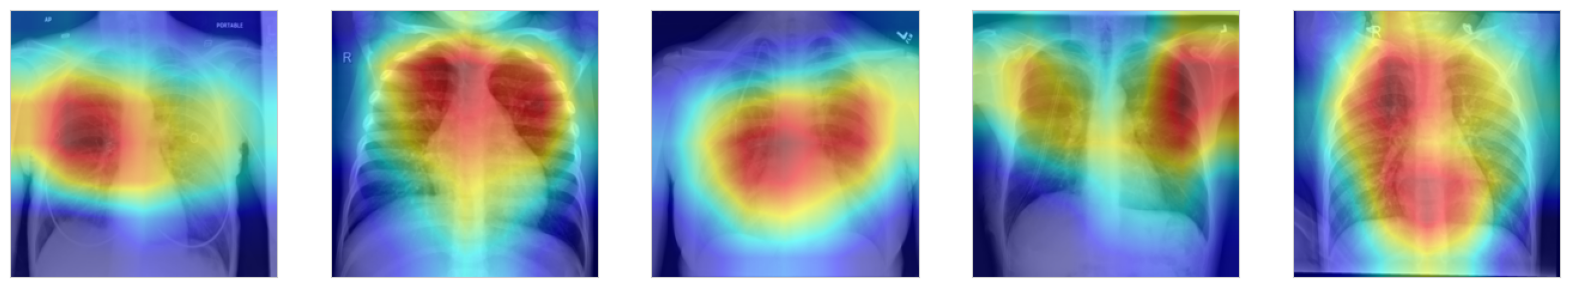

In [40]:
# Move the ResNet-18 model to the CPU
resnet18 = resnet18.cpu()

# Get a batch of images and labels from the test_loader
images, labels = next(iter(test_loader))

# Define the target layer for Grad-CAM, selecting the last block of ResNet-18's layer4
target_layers = [resnet18.layer4[-1]]

# Define the input tensor for Grad-CAM
input_tensor = images 

# Initialize the GradCAM object with the model and target layers
# (Removed the use_cuda parameter as the model is already on the correct device)
cam = GradCAM(model=resnet18, target_layers=target_layers)

# Generate the Grad-CAM heatmap; the highest-scoring category will be used by default
grayscale_cam = cam(input_tensor=input_tensor)

# Set up a figure to display multiple Grad-CAM images side by side
plt.figure(figsize=(20, 6))

# Loop through the first 5 images in the batch to visualize their Grad-CAM results
for i in range(5):
    
    # Define the image path from the test dataset (ensure this is valid for your dataset structure)
    image_path = test_dataset.images[i]
    
    # Load the image using OpenCV in BGR format and convert to RGB by reversing channels
    rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
    
    # Resize the image to 224x224 to match the input size expected by ResNet-18
    rgb_img = cv2.resize(rgb_img, (224, 224))
    
    # Normalize the image to float32 with pixel values in range [0, 1]
    rgb_img = np.float32(rgb_img) / 255

    # Create a subplot for each Grad-CAM visualization (in a 1x5 grid) with no axis ticks
    plt.subplot(1, 5, i + 1, xticks=[], yticks=[])
    
    # Retrieve the Grad-CAM heatmap for the current image
    cam_heatmap = grayscale_cam[i, :]

    # Overlay the heatmap on the RGB image using the show_cam_on_image function
    visualization = show_cam_on_image(rgb_img, cam_heatmap, use_rgb=True)

    # Display the final Grad-CAM visualization for the image
    plt.imshow(visualization)

# Show the full plot with all Grad-CAM visualizations
plt.show()


In [41]:
# Assuming `resnet18` is your trained model
# Save the model's state_dict
torch.save(resnet18.state_dict(), 'model.pth')